#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
# импорт библиотек
import pandas as pd
import numpy as np
import time
#import optuna

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from catboost import CatBoostRegressor


from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit

from sklearn.preprocessing import StandardScaler, OrdinalEncoder

from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

pd.options.mode.chained_assignment = None

import seaborn as sns
import os

In [2]:
# загрузка данных
if os.path.exists('/datasets/taxi.csv'):
    df = pd.read_csv('/datasets/taxi.csv', parse_dates=[0], index_col='datetime')

else:
    df = pd.read_csv('/Users/olesya/datasets/taxi.csv', parse_dates=[0], index_col='datetime')


In [3]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [4]:
# проверка на правильность хронологического порядка
df.index.is_monotonic

True

In [5]:
# проверка пропусков
df.isnull().sum()

num_orders    0
dtype: int64

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Имеем данные с 1 марта по 31 августа 2018, пропусков нет, таблица отсортирована. Один столбец "num_orders" - количество заказов такси и временной индекс. Переходим к анализу.

## Анализ

Проанализируем данные. Выполним ресемплирование по одному часу.

In [7]:
# ресемплирование по одному часу с суммированием 
df = df.resample('1H').sum()


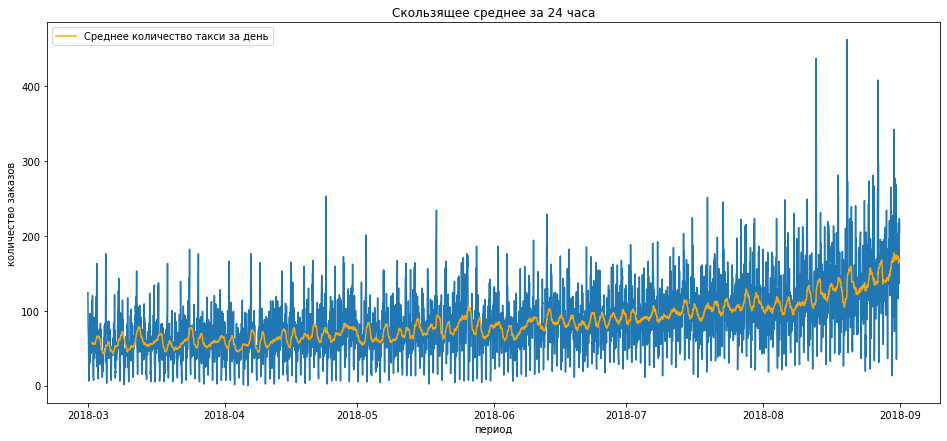

In [8]:
# скользящее среднее за 24 часа
hour = df['num_orders'].rolling(24).mean()

fig, ax = plt.subplots(figsize=(16, 7))
ax.plot(df)
ax.plot(hour, color="orange", label="Среднее количество такси за день")

plt.title("Cкользящее среднее за 24 часа")
plt.xlabel("период")
plt.ylabel("количество заказов")
plt.legend();

Рассмотрим тренды и сезонность.

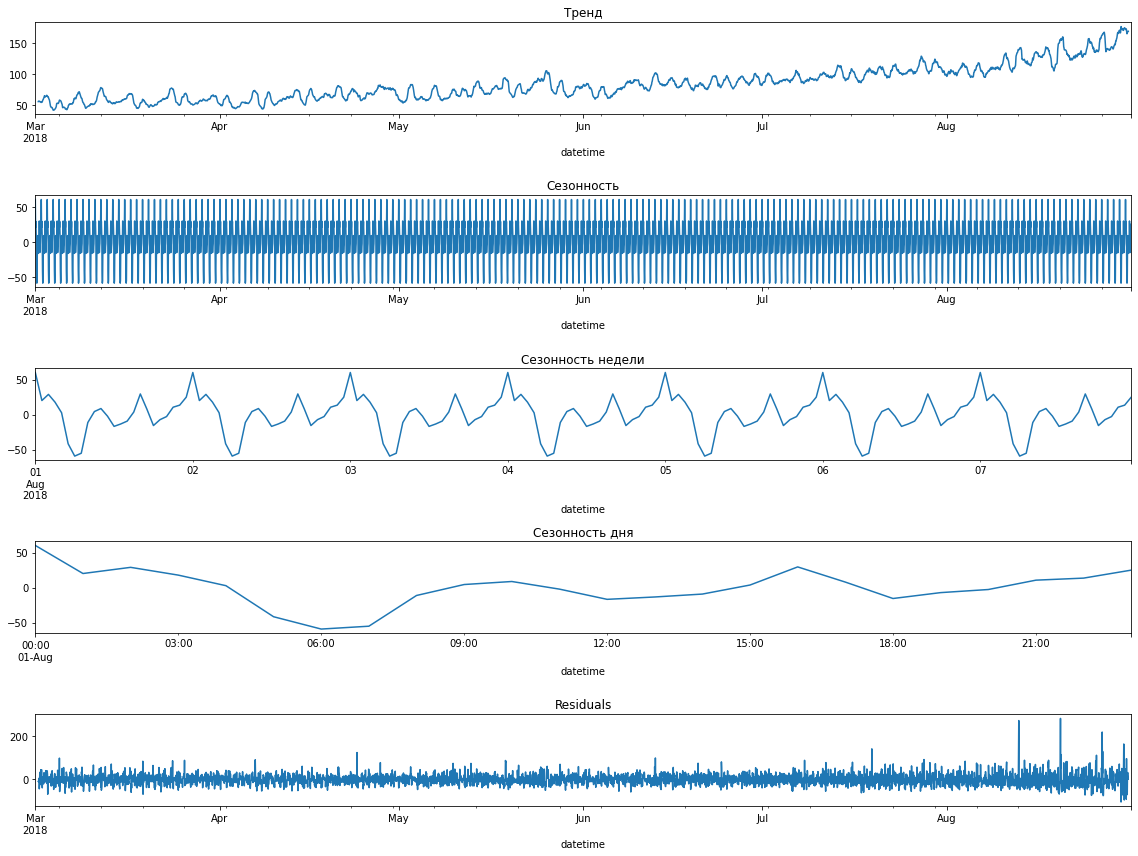

In [9]:
decomposed = seasonal_decompose(df['num_orders']) 

plt.figure(figsize=(16, 12))
plt.subplot(511)

decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд')
plt.subplot(512)

decomposed.seasonal.plot(ax=plt.gca())
plt.title('Сезонность')
plt.subplot(513)

decomposed.seasonal['2018-08-01':'2018-08-07'].plot(ax=plt.gca())
plt.title('Сезонность недели')
plt.subplot(514)

decomposed.seasonal['2018-08-01 00:00:00':'2018-08-01 23:59:59'].plot(ax=plt.gca())
plt.title('Сезонность дня')
plt.subplot(515)

decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

Мы видим возрастающий тренд и ежедневную сезонность. 

- Общее количество заказов растет с каждым месяцем
- Пик заказов приходится на 12 часов ночи, к 6 часам утра количество заказов падает, а вечером он плавно возрастает

## Обучение

Обучим разные модели с различными гиперпараметрами.

Для этого рассмотрим 3 модели:

- LinearRegression
- DecisionTreeRegressor
- CatBoost

In [10]:
# создание итоговой таблицы
models= pd.DataFrame(columns = ['model', 'rmse_train'])

Напишем функцию для создания признаков и целевого признака, а также деления датасета на обучающую и тестовую выборки в пропорциях (90% и 10%).

In [11]:
def make_features(df, max_lag, rolling_mean_size):
    taxi = df.copy()
    
    taxi['hour'] = taxi.index.hour
    taxi['dayofweek'] = taxi.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        taxi['lag_{}'.format(lag)] = taxi['num_orders'].shift(lag)

    taxi['rolling_mean'] = taxi['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    # деление данных на обучающую и тестовую выборки
    train, test = train_test_split(taxi, shuffle=False, test_size=0.1)
    train = train.dropna()

    # создание признаков и целевого признака
    target_train = train['num_orders']
    features_train = train.drop(['num_orders'], axis=1)
    target_test = test['num_orders']
    features_test = test.drop(['num_orders'], axis=1)

    return (target_train, features_train, target_test, features_test)

Подберём наилучшие аргументы для создания признаков и проверим на модели <b>LinearRegression</b>

In [12]:
rmse_ = 1000
for lag in range(1, 30):
    for size in range(1, 30):
        target_train, features_train, target_test, features_test = make_features(df, lag, size)
        
        # обучение модели
        model_lr = LinearRegression()
        model_lr.fit(features_train, target_train)
        
        predict_train_lr = model_lr.predict(features_train)
        
        rmse_train_lr = mean_squared_error(target_train, predict_train_lr) ** 0.5
        if rmse_train_lr < rmse_:
            rmse_ = rmse_train_lr
            best_lag = lag
            best_rolling_size = size
       
print('RMSE линейной регрессии на обучающей выборке:', rmse_)
print('max_lag:', best_lag, 'rolling_mean_size:', best_rolling_size)

# добавление результата в итоговую таблицу
models = models.append({'model': 'LinearRegression', 'rmse_train': rmse_train_lr}, ignore_index=True)

RMSE линейной регрессии на обучающей выборке: 25.574005196972806
max_lag: 29 rolling_mean_size: 1


Проверим эти параметры max_lag и rolling_mean_size на моделях DecisionTreeRegressor и CatBoost. 

<b>DecisionTreeRegressor</b>

Подберём наилучшие гиперпараметры для модели Решаюшее дерево

In [13]:
model_tree = DecisionTreeRegressor(random_state=12345)

In [14]:
target_train, features_train, target_test, features_test = make_features(df, 29, 1)

In [15]:
# диапазон параметров для поиска наилучшего
params = {'max_depth':np.arange(1,15),
         'min_samples_split':np.arange(2,11),
         'min_samples_leaf':np.arange(1,11)}

In [16]:
tscv = TimeSeriesSplit(n_splits=9)
gsearch = GridSearchCV(estimator=model_tree, param_grid=params, scoring='neg_mean_squared_error', cv=tscv)
gsearch.fit(features_train, target_train)
best_tree = gsearch.best_estimator_
best_tree

DecisionTreeRegressor(max_depth=6, min_samples_leaf=7, random_state=12345)

Прооверим модель DecisionTreeRegressor с наилучшими параметрами и ранее высчитанными аргументами для создания признаков

In [17]:
# обучение модели
model_tree_best = DecisionTreeRegressor(max_depth=6, min_samples_leaf=7, random_state=12345)
model_tree_best.fit(features_train, target_train)

predict_train_tree = model_tree_best.predict(features_train)

rmse_train_tree = mean_squared_error(target_train, predict_train_tree) ** 0.5
print('RMSE решающего дерева на обучающей выборке:', rmse_train_tree)

# добавление результата в итоговую таблицу
models = models.append({'model': 'DecisionTreeRegressor', 'rmse_train': rmse_train_tree}, ignore_index=True)

RMSE решающего дерева на обучающей выборке: 23.47287337358901


<b>CatBoost</b>

In [18]:
model_cat = CatBoostRegressor(iterations=100, loss_function="RMSE")

In [19]:
target_train, features_train, target_test, features_test = make_features(df, 29, 1)

Прооверим модель CatBoost с ранее высчитанными аргументами для создания признаков

In [20]:
# обучение модели
model_cat.fit(features_train, target_train, verbose=False) 

predict_train_cat = model_cat.predict(features_train)

rmse_train_cat = mean_squared_error(target_train, predict_train_cat) ** 0.5
print('RMSE решающего дерева на обучающей выборке:', rmse_train_cat)

# добавление результата в итоговую таблицу
models = models.append({'model': 'CatBoost', 'rmse_train': rmse_train_cat}, ignore_index=True)

RMSE решающего дерева на обучающей выборке: 13.690195843056706


In [21]:
models

,model,rmse_train
0,LinearRegression,25.574143
1,DecisionTreeRegressor,23.472873
2,CatBoost,13.690196


По результатам видим, что наилучший результат на обучающей выборке показала модель CatBoostRegressor с полученным RMSE - 13.69.
Проверим модели на тестовых выборках.

## Тестирование

Проверим качество на тестовой выборке

In [22]:
#LinearRegression
model_lr = LinearRegression()
model_lr.fit(features_train, target_train)
predict_lr = model_lr.predict(features_test)

rmse_lr = mean_squared_error(target_test, predict_lr) ** 0.5
print('RMSE линейной регрессии на тестовой выборке:', rmse_lr)

RMSE линейной регрессии на тестовой выборке: 45.24626258270772


In [23]:
#DecisionTreeRegressor
predict_tree = model_tree_best.predict(features_test)

rmse_tree = mean_squared_error(target_test, predict_tree) ** 0.5
print('RMSE решающего дерева на тестовой выборке:', rmse_tree)

RMSE решающего дерева на тестовой выборке: 53.10478207176347


In [24]:
#CatBoost
predict_cat = model_cat.predict(features_test)

rmse_cat = mean_squared_error(target_test, predict_cat) ** 0.5
print('RMSE решающего дерева на тестовой выборке:', rmse_cat)

RMSE решающего дерева на тестовой выборке: 41.19529494598003


In [25]:
models['rmse_test'] = ['45.25', '53.10', '41.20']
models

,model,rmse_train,rmse_test
0,LinearRegression,25.574143,45.25
1,DecisionTreeRegressor,23.472873,53.10
2,CatBoost,13.690196,41.20


### Вывод

В проекте был проанализирован временной ряд с данными о заказах такси в аэропортах. Для предсказания количества заказов такси на следующий час были проверены три модели: LinearRegression, DecisionTreeRegressor и CatBoostRegressor. На тестовой выборке лучший результат метрики RMSE показала модель CatBoostRegressor и составила 41.20.